# Regression, continued

### Sean Trott

### CSS Bootcamp

In [1]:
## Imports
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy.stats as ss

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

# High-level learning outcomes of this week

##### [Null Hypothesis Significance Testing (NHST)](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing)

- **Explain** the theoretical foundations  
- **Implement** a t-test in Python  
- **Evaluate** the result of a given test


##### [Linear regression](https://en.wikipedia.org/wiki/Linear_regression): 

- **Implement** using Python
- **Interpret** coefficients, **examine** residuals, and **predict** new data  


##### [Beyond linear regression](https://en.wikipedia.org/wiki/Generalized_linear_model): 

- **Explain** the motivation for mixed/multilevel models  
- **Implement** other families of regression models (e.g., logistic regression)

# Today's focus

- **Identify** common pitfalls with regression models.  
- **Explain** the motivation for mixed/multilevel models.  
- **Implement** mixed/multilevel models in Python.

# Part 0: Review

## What we've learned so far

- Philosophy and practice of NHST: 
 - Statistics is the quantification and interpretation of **variation**.  
 - Although we're (typically) interested in a *population parameter* ($\mu$), we (typically) only have access to a *sample statistic* ($\bar{X}$).  
 - Because of **sampling error**, $\bar{X} ≠ \mu$.  
 - NHST gives us tools to estimate the **probability** that two or more samples came from the same population.  
- Linear regression and more: 
 - **Statistical models** allow us to fit parameters $\beta$ to predict $Y$ from $X$.  
 - These parameters can yield **inferences** (i.e., using NHST), and can also be used to make **predictions**.  
 - [Generalized linear models (GLMs)](https://en.wikipedia.org/wiki/Generalized_linear_model) are a powerful class of model under the regression framework.  

# Part 1: Pitfalls

### Two common issues researchers encounter with regression.

## Pitfall 1: [Berkson's paradox](https://en.wikipedia.org/wiki/Berkson%27s_paradox)

Consider this scenario:

> A researcher measures the **trustworthiness** and **newsworthiness** of published scientific findings. Surprisingly, the researcher finds a negative correlation: findings rated as more trustworthy tend to be less newsworthy, and vice versa. The researcher concludes that researchers interested in "flashy" findings must be untrustworthy––and conversely, trustworthy researchers are boring. 

## Check-in: Is this conclusion justified? Why or why not?

## Conditioning on a collider

- The researcher is considering only **published research**.  
- To be published, academic findings must be *either* (or both):  
 - Trustworthy. 
 - Newsworthy. 
- This publication filter is called a **collider**. 
- **Conditioning on a collider** can introduce spurious relationships.  

### Berkson's paradox in action

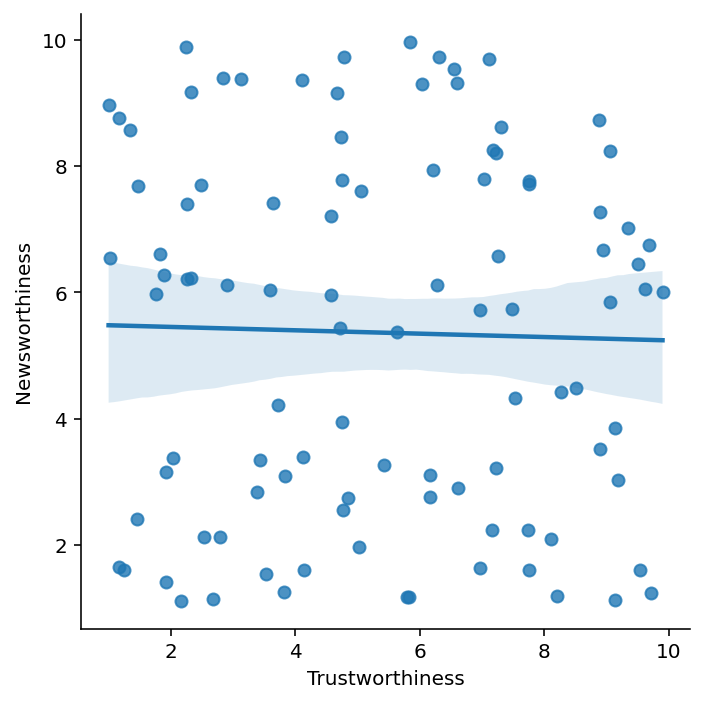

In [3]:
np.random.seed(1)
trustworthiness = np.random.uniform(low = 1, high = 10, size = 100)
newsworthiness = np.random.uniform(low = 1, high = 10, size = 100)
df_results = pd.DataFrame({'Trustworthiness':trustworthiness, 'Newsworthiness':newsworthiness})
sns.lmplot(data = df_results,
               x = 'Trustworthiness',
               y = 'Newsworthiness')

### Berkson's paradox in action

In [4]:
## Now, let's filter out results that aren't sufficiently trustworthy
df_results = df_results[df_results['Trustworthiness']>6]
## ...and results that aren't sufficiently newsworthy
df_results = df_results[df_results['Newsworthiness']>6]

### Berkson's paradox in action

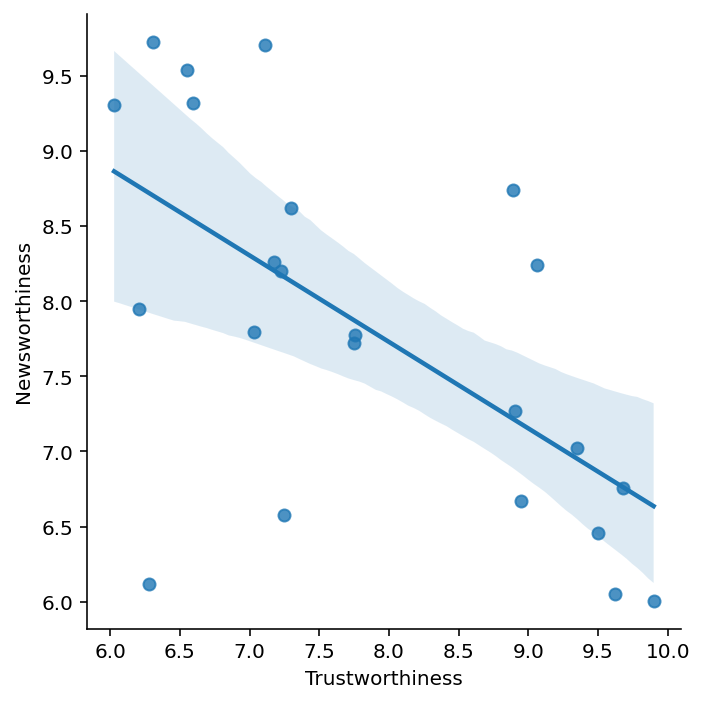

In [5]:
sns.lmplot(data = df_results,
               x = 'Trustworthiness',
               y = 'Newsworthiness')

## Pitfall 1: [Berkson's paradox](https://en.wikipedia.org/wiki/Berkson%27s_paradox)

- Without considering the **generative process** responsible for your data, you might be conditioning on a collider.  
- This can introduce spurious relationships, which is known as [Berkson's paradox](https://en.wikipedia.org/wiki/Berkson%27s_paradox).  
 - Also called the **selection-distortion effect**.  
- It's helpful to *diagram* the processes that gave rise to your data using a graph. 

## Pitfall 2: Non-independence

- A central assumption of linear (and logistic) regression is **independence**.  
- We assume no *systematic correlation* between our observations.
- This assumption is not always correct!

### Check-in: Examples of non-independence in a dataset?

## Pitfall 2: Non-independence

- In lab experiments, **non-independence** often shows up as:  
 - Multiple responses by the same subject (e.g., a human or [rat](https://link.springer.com/article/10.1186/1471-2202-11-5)). 
 - Multiple responses to the same item (i.e., from different subjects).  
- But **non-independence*** also shows up in non-experimental data.  
 - In Linguistics: [multiple languages from the same language family or geographic region](https://www.degruyter.com/document/doi/10.1515/ling-2019-0049/html?lang=en). 
 - In Sociology and Economics: multiple observations from the same school, city, state, etc.  
 - In Ecology: [multiple observations from the same mammal, etc.](https://esajournals.onlinelibrary.wiley.com/doi/10.2307/1942661).  

## Unpacking terminology

- [This paper](https://link.springer.com/article/10.1186/1471-2202-11-5) offers a useful breakdown of terminology that often gets conflated in experimental studies:
 - **Experimental unit**: smallest entity that can be assigned to conditions (e.g., a human or rat).  
 - **Sample size**: number of experimental units (reported as $n$).  
 - **Observation**: outcome of a measurement
- Note that multiple measures can be taken from each experimental unit, so $n$ is *not always* the number of observations.
- If multiple observations are taken from the same experimental unit, then those observations are not independent!

### What happens when we violate this assumption?

- ["Pseudo-replication"](https://esajournals.onlinelibrary.wiley.com/doi/10.2307/1942661): confusion of the number of *data points* with the number of *independent samples*.  
- [It can inflate our chance of a false positive result](https://bodowinter.com/tutorial/bw_LME_tutorial1.pdf).  
 - E.g., if one subject is over-represented in our data, we might "over-index" on their behavior specifically.   
- It can bias our parameter estimates (and estimates of standard error).  
- More generally: we're not being fair with our model.  
 - Models do what they're told.  
 - Even if *we* know about non-independence in our data, statistical model treats each point as independent unless we tell it otherwise.

## The statistical problem

- Violations of the **independence assumption** are common across many fields, including [neuroscience](https://link.springer.com/article/10.1186/1471-2202-11-5), [ecology](https://esajournals.onlinelibrary.wiley.com/doi/10.2307/1942661), [psychology](https://www.cambridge.org/core/journals/behavioral-and-brain-sciences/article/abs/generalizability-crisis/AD386115BA539A759ACB3093760F4824), [phonetics](https://bodo-winter.net/papers/Winter_2012_pseudoreplication.pdf), and more.  
- Traditional formula of the regression model do not make it easy to account for non-independence.  
- We need away to "tell" our model about **nested group structure** in our data.

# Part 2: Foundations of mixed/multilevel models

## Background

- [Mixed models](https://en.wikipedia.org/wiki/Mixed_model) (also called **multilevel** or **hierarchical models**) are a powerful statistical tool for handling [repeated-measures data](https://en.wikipedia.org/wiki/Repeated_measures_design).
 - Multiple observations from same `subject`, same `item`, same `school`...
- Now widely used in [psycholinguistics](https://www.sciencedirect.com/science/article/pii/S0749596X12001180?casa_token=16lbbHuwPvYAAAAA:y9tAupkBWhbiQMxW4wzN21Bw4bYloBXW2pxZdweoNSXtA56-EjnyoTtkqRp8FGuxkT390I9GKSo), gaining traction in other fields as well. 
- As with other topics, this intro will be *brief*, but there are many useful resources for diving deeper. 
 - I have a [tutorial]((https://seantrott.github.io/mixed_models_R/)) on mixed models in R.  
 - Bodo Winter has an excellent [book](https://bodowinter.com/books.html) on statistics for linguists, which includes mixed models.  
 - [Barr et al. (2013)](https://www.sciencedirect.com/science/article/pii/S0749596X12001180?casa_token=16lbbHuwPvYAAAAA:y9tAupkBWhbiQMxW4wzN21Bw4bYloBXW2pxZdweoNSXtA56-EjnyoTtkqRp8FGuxkT390I9GKSo) is now a classic, as is [Bates et al. (2015)](https://arxiv.org/abs/1506.04967).  
 - Andrew Gelman has an entire [book](http://www.stat.columbia.edu/~gelman/arm/) on the subject. 

## Goals of this mini-tutorial

- Motivation for using mixed models (we already covered this: **non-independence**).  
- Conceptual foundations:
 - Random vs. fixed effects.  
 - Partial pooling.  
 - What is a "random intercept" vs. a "random slope"?  
- Mixed models in Python. 

## Check-in: when should we use a mixed model?

## Check-in: when should we use a mixed model?

**Answer**: when the data have **nested structure** we want/need to account for. 
- I.e., there is *non-independence* in our dataset.  

## Example of non-independence

- Dataset investigating [bounce rates on a cooking website](https://www.kaggle.com/code/ojwatson/mixed-models/notebook) (also a very useful tutorial!).  
- Primary question: is there a correlation between `age` and `bounce_time`? 
- Non-independence:
 - Multiple observations from a given `county` and `location`.  

In [6]:
df_bounce = pd.read_csv("data/lecture/bounce.csv")
df_bounce.head(3)

,bounce_time,age,county,location
0,165.548520,16,devon,a
1,167.559314,34,devon,a
2,165.882952,6,devon,a


## What is a mixed model?

- Mixed models are "mixed" because they can include two kinds of predictors:  
 - **Fixed** effects.  
 - **Random** effects.  
- Fixed effects are what we're used to with ordinary regression.
 - Denoted by $X$.  
 - Learn vector of parameters $\beta$ for $X$.
- Random effects are used to account for correlated structure (e.g., `county`).  
 - Sometimes denoted by $Z$.  
 - Learn vector of parameters $\eta$ for $Z$.  

## Why not all fixed effects?

- This seems complicated––why don't we just add a **fixed effect** of something like `county`?  
 - In fact, we could do this...it just ends up being noisy, especially if there are many groups.  
- There are three ways to handle non-independence:  
 - **Complete pooling**: ignore between-`county` variance, just average across.  
   - This is what we do *implicitly* when we ignore `county` in our model.  
   - E.g., `bounce_time ~ age`
   - This is bad because it ignores important variation. 
 - **No pooling**: calculate a separate *intercept* for each `county`.  
   - E.g., `bounce_time ~ age + county`
   - This ends up with very noisy parameter estimates. 
 - **Partial pooling**: calculate a separate *intercept* for each `county`, but assume they're drawn from the **same distribution**.
   - In this case, the intercepts are drawn towards the *mean* of that distribution.  

## Pooling and error

- **Complete pooling**: ignore between-`county` variance, just average across.  
 - This is what we do *implicitly* when we ignore `county` in our model.  
 - E.g., `bounce_time ~ age`
 - This is bad because it ignores important variation. 
- **No pooling**: calculate a separate *intercept* for each `county`.  
 - E.g., `bounce_time ~ age + county`
 - This ends up with very noisy parameter estimates. 
- **Partial pooling**: calculate a separate *intercept* for each `county`, but assume they're drawn from the **same distribution**.
 - In this case, the intercepts are drawn towards the *mean* of that distribution.  
 - This is sometimes called **shrinkage**.  

## Random intercepts vs. random slopes

- An ordinary regression model wouldn't account for any variance in `county`.  

$y_i = \alpha + \beta_ix_i + \epsilon_i$


- A **random intercept** model accounts for variation in $Y$ as a function of our random effect.  
 - Example: perhaps different levels of `county` have different `bounce_time` on average. 
 
$y_i = \alpha_{j[i]} + \beta_ix_i + \epsilon_i$


- A **random slope** acounts for variation in the effect of $X_1$ on $Y$.
 - Example: perhaps the relationship between `bounce_time ~ age` is different across counties!
 
$y_i = \alpha + \beta_{j[i]}x_i + \epsilon_i$


- We can also have a **random intercept** *and* a **random slope**.


## FAQ 1: Random vs. fixed effect?

- This is a [common question](https://seantrott.github.io/mixed_models_R/#Which_effects_are_fixed,_and_which_are_random), and there's really no definitive answer.  
- Many different ways to think about it:
 - Am I interested in modeling these effects directly (fixed) or are they just related to the population I'm modeling (random)?   
 - Does a sample *exhaust* a population (fixed) or not (random)?  
 - Do I want to estimate the coefficients using maximum likelihood estimation (fixed) or *shrinkage* (random)? 


## FAQ 2: Random slope vs. random intercept?

-  [Barr et al. (2013)](https://www.sciencedirect.com/science/article/pii/S0749596X12001180?casa_token=16lbbHuwPvYAAAAA:y9tAupkBWhbiQMxW4wzN21Bw4bYloBXW2pxZdweoNSXtA56-EjnyoTtkqRp8FGuxkT390I9GKSo) say to "keep it maximal" 
 - Start with maximal model (random slopes + random intercepts), then reduce as needed for *convergence*.  
 - Good for avoiding false positives.  
- But [Bates et al. (2015)](https://arxiv.org/abs/1506.04967) say we should aim for *parsimonious* mixed models.  
 - In practice, not *that* different. 
 - Identify which sources of non-independence explain significant variance in data, and keep those in the model. 


## FAQ 3: Is a fixed effect significant?

- In ordinary regression, we can run a **t-test** on our parameter estimate to determine significance.  
- There's considerable debate about whether this is licensed for mixed models.  
 - Less clear what appropriate $df$ is given that there are now two design matrices.  
- Instead, best practice is to run a **likelihood ratio test**.  
 - I.e., drop parameter of interest from model––how much does it hurt the model?  



## But how does this all work in practice?


# Part 3: Mixed models in Python

## Caveat: Python vs. R

- I primarily use **R** for statistical analysis, particularly mixed models. 
 - See [documentation](https://www.rdocumentation.org/packages/lme4/versions/1.1-30/topics/lmer) on the `lmer` package.  
- However, our familiar `statsmodels` package *can* fit mixed models.  
 - See [documentation](https://www.statsmodels.org/dev/examples/notebooks/generated/mixed_lm_example.html) here.  
- Some differences in the syntax and sumary tables.


## Working example: bounce times

Does `age` explain variation in `bounce_time`?

In [7]:
df_bounce.head(5)

,bounce_time,age,county,location
0,165.548520,16,devon,a
1,167.559314,34,devon,a
2,165.882952,6,devon,a
3,167.685525,19,devon,a
4,169.959681,34,devon,a


## Round 1: complete pooling

- Ignoring `county` altogether, let's look at `bounce_time ~ age`.  

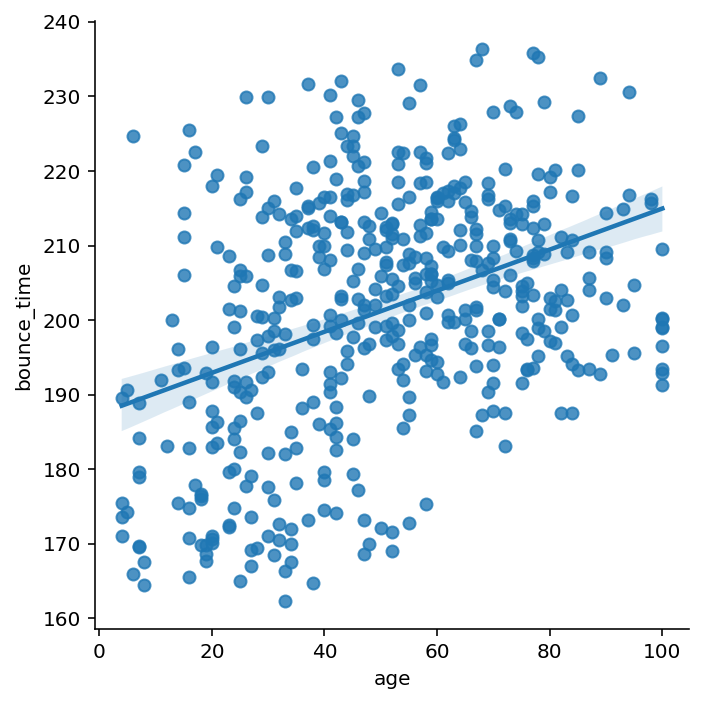

In [8]:
sns.lmplot(data = df_bounce, x = 'age', y = 'bounce_time')

## Round 1: complete pooling

- Ignoring `county` altogether, let's look at `bounce_time ~ age`.  

In [9]:
md = smf.ols(data = df_bounce, formula = 'bounce_time ~ age').fit()
md.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            bounce_time   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     84.58
Date:                Sun, 14 Aug 2022   Prob (F-statistic):           1.14e-18
Time:                        20:30:47   Log-Likelihood:                -1978.7
No. Observations:                 480   AIC:                             3961.
Df Residuals:                     478   BIC:                             3970.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    187.4091      1.659    112.951      0.000     184.149     190.669
age            0.2755      0.030      9.197      0.000       0.217       0.334
==============================================================================
Omnibus:                       12.593   Durbin-Watson:                   0.383
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                6.671
Skew:                           0.019   Prob(JB):                       0.0356
Kurtosis:                       2.424   Cond. No.                         135.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Check-in: is there an issue with this model? What is it?

### Variance in `bounce_time` by `county`

/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


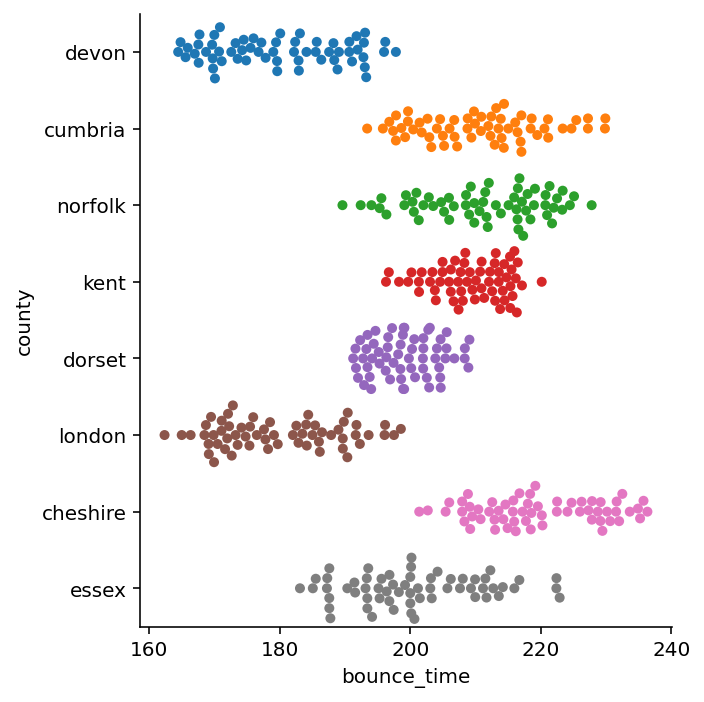

In [10]:
sns.catplot(y="county", x="bounce_time", data=df_bounce, kind = "swarm")

### Variance in `age` by `county`

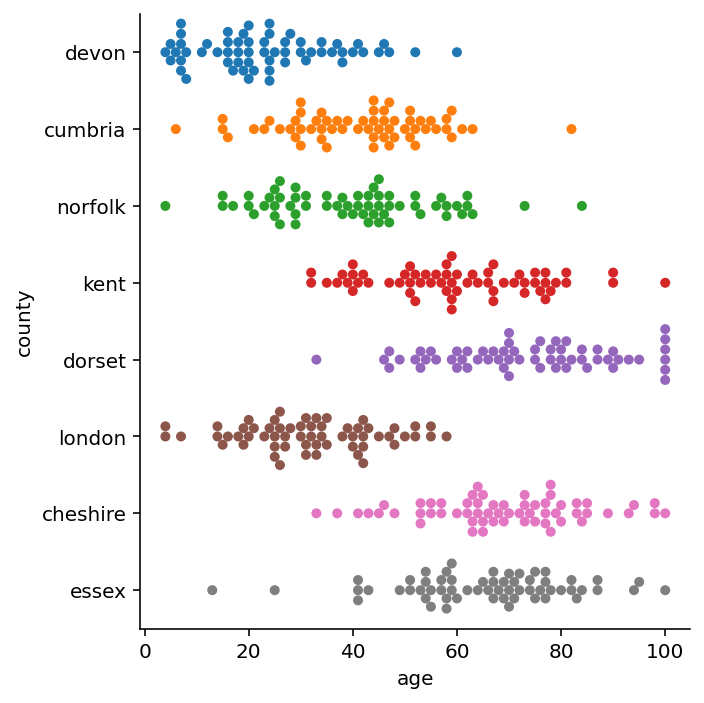

In [11]:
sns.catplot(y="county", x="age", data=df_bounce, kind = "swarm")

## Interim conclusion

- `age` is positively correlated with `bounce_time`.  
- But `bounce_time` is also different across different `county` levels.  
- Further, `age` is *also* different across `county` levels.  
- What if `county` is driving the `age` effect? 
 - Shark attacks and ice cream sales all over again!


### Round 2: partial pooling

- Now let's use `mixedlm`, and add a **random intercept** for `county`.

In [12]:
md = smf.mixedlm("bounce_time ~ age", df_bounce, groups=df_bounce["county"]).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: bounce_time
No. Observations: 480     Method:             REML       
No. Groups:       8       Scale:              74.7350    
Min. group size:  60      Log-Likelihood:     -1736.1660 
Max. group size:  60      Converged:          Yes        
Mean group size:  60.0                                   
---------------------------------------------------------
             Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   201.016    5.350 37.574 0.000 190.531 211.502
age           0.006    0.027  0.221 0.825  -0.047   0.059
Group Var   212.999   13.382                             
=========================================================

"""

### Dissecting the `mixedlm` syntax

`statsmodels` has a function called `mixedlm`.

```
mixedlm(
    formula = ... # string formula, as with ols or logit
    data = ... # dataframe, as with ols or logit
    groups = ... # vector representing grouping factors
)
```

A number of other parameters too, which we'll see in a moment.



### Is `age` significant?

- At least two approaches here...
- Approach 1: run a **t-test** on $\beta$ for `age`.  
 - `statsmodels` does this automatically.  
 - Controversial whether this is "licensed".
- Approach 2: run a **log-likelihood ratio test** (LRT). 
 - Call `model.llf` to get log likelihood, compare to LL of a reduced model.
 - This is much more widely accepted. 

### Approach 1: t-test on $\beta$

**Result**: Doesn't look significant after accounting for `county`-level variance ($p > .05$). 

In [13]:
md.tvalues

Intercept    37.574390
age           0.221327
Group Var     1.841218
dtype: float64

In [14]:
md.pvalues

Intercept    5.632591e-309
age           8.248381e-01
Group Var     6.558965e-02
dtype: float64

### Approach 2: LRT

- First, get log likelihood of full model.  

In [15]:
md.llf

-1736.166045018357

### Approach 2: LRT

- First, get log likelihood of full model.  
- Then, build a *reduced* model (i.e., without `age`) and get the LL of that.

In [16]:
md_reduced = smf.mixedlm("bounce_time ~ 1", df_bounce, groups=df_bounce["county"]).fit()
md_reduced.llf

-1733.4894825258061

### Approach 2: LRT

- First, get log likelihood of full model.  
- Then, build a *reduced* model (i.e., without `age`) and get the LL of that.  
- Then, use LRT formula:

$\Large \delta = -2 * (log(L(M_{k-1})) - log(L(M_{k})))$


- As it turns out, LRT result follows a **chi-squared distribution**.  
 - This means we can run a significance test on the result. 

### Caveat

- Typically, the result of an LRT is *positive*.  
 - This is because in the absence of cross-validation, adding parameters typically only *improves* model fit.  
 - Thus, LL is usually *higher* for our reduced model (or at least no smaller).
- However, in *this* particular case, `statsmodels` is giving a lower LL to our reduced model.
 - Notably, this is different from the behavior in `lmer` (in R). 
 - This results in a *negative* LRT result.  
 - For our purposes, we can treat this negative LRT result as *very clearly* not an improvement in the full model.  

### Approach 2: LRT

- In this case, LRT yields a negative value...
- I.e., full model has *worse fit* than reduced model.  
- Nevertheless, for the purposes of demonstration, we can still ask about $p(\chi^2)$ under the appropriate distribution.

In [47]:
lrt = -2 * (md_reduced.llf - md.llf)
lrt 

-5.353124985101658

### Approach 2: LRT

- We can look up this value of $\chi^2$ in a chi-squared distribution with the appropriate $df$.  
- The correct $df$ corresponds to the **difference in number of parameters between the full and reduced model**. 
- As demonstrated here, the LRT is not significant.
 - Note that this example is a little strange, given that $\chi^2$ is one-tailed test.  

In [48]:
diff_parameters = 1
ss.chi2.sf(lrt, df=diff_parameters)

1.0

## What about random slopes?

For **random slopes**, use the `re_formula` parameter, and add the fixed effect you want to calculate by-`county` random slopes for.

Example:

```
md = smf.mixedlm("bounce_time ~ age", df_bounce, re_formula = "age", groups=df_bounce["county"])
```

## Wrapping up: Mixed models

- As noted, much more complexity here than we can realistically cover.  
- But hopefully this was a relatively gentle intro to the concepts and implementation in Python.
 - Note that R has a package as well called `lmer` (which I actually prefer!).  
- See also the resources linked earlier for more details.

# High-level learning outcomes of this week

##### [Null Hypothesis Significance Testing (NHST)](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing)

- **Explain** the theoretical foundations  
- **Implement** a t-test in Python  
- **Evaluate** the result of a given test


##### [Linear regression](https://en.wikipedia.org/wiki/Linear_regression): 

- **Implement** using Python
- **Interpret** coefficients, **examine** residuals, and **predict** new data  


##### [Beyond linear regression](https://en.wikipedia.org/wiki/Generalized_linear_model): 

- **Explain** the motivation for mixed/multilevel models  
- **Implement** other families of regression models (e.g., logistic regression)